In [0]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 150

# Initialization

Here we assume $f = 5$ and $λ = 0.1$. For initialization, set $X_0$ as a matrix with all elements $= 0.5$ and $Y_0$ as a zero matrix. Run your program for $1000$ iteration.

In [0]:
n_iters = 1000
n_user = 100
n_item = 100

f = 5
_lambda = 0.1

#  Sparsity Ratio $α$ 

In [0]:
data_small = pd.read_csv('user_artists_small.txt', sep = "\t", header=0, names=['userID', 'artistID', 'interactions'])
data_synthetic = pd.read_csv('user_artists_synthetic.txt', sep = "\t", header=0, names=['userID', 'artistID', 'interactions'])

In [0]:
alpha_small = len(data_small) / ((n_user * n_item) - len(data_small))
alpha_synthetic = len(data_synthetic) / (n_user * n_item - len(data_synthetic))

# Dataset: `user_artists_small.txt`

In [0]:
C = np.zeros((n_user, n_item))
P = np.zeros((n_user, n_item))
for idx, row in data_small.iterrows():
    C[row['userID']][row['artistID']] = row['interactions']
    if row['interactions'] > 0:
        P[row['userID']][row['artistID']] = 1.0 
C = C * alpha_small + 1

## Update $y_i$

$\mathbf{y}_i = \big( \mathbf{X}^T  \mathbf{X} + \mathbf{X}^T (\textbf{C}_{i} - \mathbf{I})\mathbf{X} +  \lambda \mathbf{I}  \big)^{-1} \mathbf{X}^T \textbf{C}_{i} p(i) $


## Update $x_u$

$\mathbf{x}_u = \big( \mathbf{Y}^T  \mathbf{Y} + \mathbf{Y}^T (\textbf{C}_{u} - \mathbf{I})\mathbf{Y} +  \lambda \mathbf{I}  \big)^{-1} \mathbf{Y}^T \textbf{C}_{u} p(u) $

In [0]:
X = np.full((n_user, f), 0.5)
Y = np.full((n_item, f), 0.0)
c_implicit_history = []
lambda_I = _lambda * np.eye(f)

for iter in range(n_iters):
    # step0: precompose XtX
    Xt_X = np.matmul(X.T, X)

    # step1: update item matrix Y
    for i in range(n_item):

        Ci = np.diag(C[:,i])
        Ci_minus_I = Ci - np.eye(n_item)

        Xt_Ci_pi = np.matmul(X.T, np.multiply(C[:,i], P[:,i]))

        Y[i,:] = np.matmul(np.linalg.inv(Xt_X + np.matmul(np.matmul(X.T, Ci_minus_I), X) + lambda_I), Xt_Ci_pi)

    # step0: precompose YtY
    Yt_Y = np.matmul(Y.T, Y)
    # step2: update item matrix Y
    for u in range(n_user):
        
        Cu = np.diag(C[u,:])
        Cu_minus_I = Cu - np.eye(n_user)

        Yt_Cu_pu = np.matmul(Y.T, np.multiply(C[u,:], P[u,:]))

        X[u,:] = np.matmul(np.linalg.inv(Yt_Y + np.matmul(np.matmul(Y.T, Cu_minus_I), Y) + lambda_I), Yt_Cu_pu)

    # step3: Caculate C_implicit
    preds = np.matmul(X, Y.T)
    c_implicit = np.sum(np.multiply(C, np.square(P - preds))) + _lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))

    c_implicit_history.append(c_implicit)

    if iter <= 9 or iter % 100 == 99:
        print("Iter {:3d}:\t C_implicit: {}\t\t p(30,83): {}".format(iter+1, c_implicit, preds[30, 83]))

Iter   1:	 C_implicit: 1527.4737190973742		 p(30,83): 0.6554300810001858
Iter   2:	 C_implicit: 1281.4324801658206		 p(30,83): 0.6406748225227045
Iter   3:	 C_implicit: 843.5666154146803		 p(30,83): 1.061303449308686
Iter   4:	 C_implicit: 415.65603929426646		 p(30,83): 0.546903839876763
Iter   5:	 C_implicit: 351.6522797641165		 p(30,83): 0.5188776542281589
Iter   6:	 C_implicit: 340.9773119832795		 p(30,83): 0.48852133561058825
Iter   7:	 C_implicit: 334.6857363002091		 p(30,83): 0.4395160416066584
Iter   8:	 C_implicit: 329.71962782703986		 p(30,83): 0.3807031426494825
Iter   9:	 C_implicit: 325.7350455235427		 p(30,83): 0.33014464108806363
Iter  10:	 C_implicit: 322.7542807199702		 p(30,83): 0.29501639634661636
Iter 100:	 C_implicit: 299.7831466241894		 p(30,83): 0.2060293499615423
Iter 200:	 C_implicit: 296.7080892679179		 p(30,83): 0.18483393140297452
Iter 300:	 C_implicit: 295.57918855811096		 p(30,83): 0.1833112287203684
Iter 400:	 C_implicit: 294.95543096685094		 p(30,83): 0.1

Text(0.5, 1.0, '$C_{implicit}$ (user_artist_small.txt)')

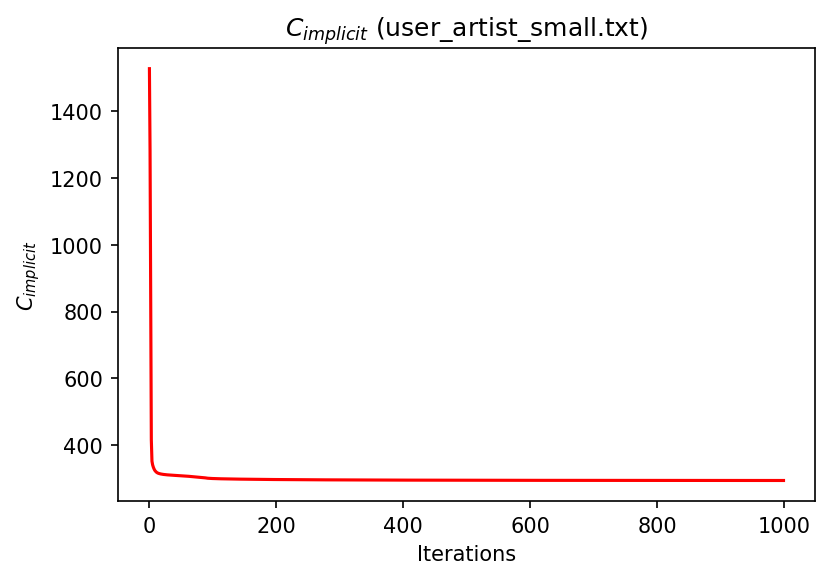

In [0]:
plt.figure()
plt.plot(np.array(c_implicit_history), c='red')
plt.xlabel('Iterations')
plt.ylabel(r'$C_{implicit}$')
plt.title(r'$C_{implicit}$' + ' (user_artist_small.txt)')

# Dataset: `user_artists_synthetic.txt`

In [0]:
C = np.zeros((n_user, n_item))
P = np.zeros((n_user, n_item))
for idx, row in data_synthetic.iterrows():
    C[row['userID']][row['artistID']] = row['interactions']
    if row['interactions'] > 0:
        P[row['userID']][row['artistID']] = 1.0 
C = C * alpha_synthetic + 1

In [0]:
X = np.full((n_user, f), 0.5)
Y = np.full((n_item, f), 0.0)
c_implicit_history = []
lambda_I = _lambda * np.eye(f)

for iter in range(n_iters):
    # step0: precompose XtX and YtY
    Xt_X = np.matmul(X.T, X)

    # step1: update item matrix Y
    for i in range(n_item):

        Ci = np.diag(C[:,i])
        Ci_minus_I = Ci - np.eye(n_item)

        Xt_Ci_pi = np.matmul(X.T, np.multiply(C[:,i], P[:,i]))

        Y[i,:] = np.matmul(np.linalg.inv(Xt_X + np.matmul(np.matmul(X.T, Ci_minus_I), X) + lambda_I), Xt_Ci_pi)

    Yt_Y = np.matmul(Y.T, Y)
    # step2: update item matrix Y
    for u in range(n_user):
        
        Cu = np.diag(C[u,:])
        Cu_minus_I = Cu - np.eye(n_user)

        Yt_Cu_pu = np.matmul(Y.T, np.multiply(C[u,:], P[u,:]))

        X[u,:] = np.matmul(np.linalg.inv(Yt_Y + np.matmul(np.matmul(Y.T, Cu_minus_I), Y) + lambda_I), Yt_Cu_pu)

    # step3: Caculate C_implicit
    preds = np.matmul(X, Y.T)
    c_implicit = np.sum(np.multiply(C, np.square(P - preds))) + _lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))

    c_implicit_history.append(c_implicit)

    if iter <= 9 or iter % 100 == 99:
        print("Iter {:3d}:\t C_implicit: {}\t\t p(30,83): {}".format(iter+1, c_implicit, preds[30, 83]))

Iter   1:	 C_implicit: 1687.619990010212		 p(30,83): 0.27675806467607506
Iter   2:	 C_implicit: 1684.4036099533012		 p(30,83): 0.23977120771858967
Iter   3:	 C_implicit: 1683.864467580794		 p(30,83): 0.23851933147863677
Iter   4:	 C_implicit: 1681.9032365850235		 p(30,83): 0.23858221593381787
Iter   5:	 C_implicit: 1441.0047120209697		 p(30,83): 0.24960662553542415
Iter   6:	 C_implicit: 1430.2685269353074		 p(30,83): 0.23849347232706192
Iter   7:	 C_implicit: 1423.6570879264466		 p(30,83): 0.23356231156468477
Iter   8:	 C_implicit: 1419.144718098784		 p(30,83): 0.23232435067388854
Iter   9:	 C_implicit: 1415.8886410656623		 p(30,83): 0.23342751576183005
Iter  10:	 C_implicit: 1413.4535845698376		 p(30,83): 0.23609605457918745
Iter 100:	 C_implicit: 1398.8870056098876		 p(30,83): 0.34525324999030493
Iter 200:	 C_implicit: 1398.6035630001306		 p(30,83): 0.3467021898718533
Iter 300:	 C_implicit: 1398.5880832184714		 p(30,83): 0.3467709925667726
Iter 400:	 C_implicit: 1398.5872117749211		

Text(0.5, 1.0, '$C_{implicit}$ (user_artist_synthetic.txt)')

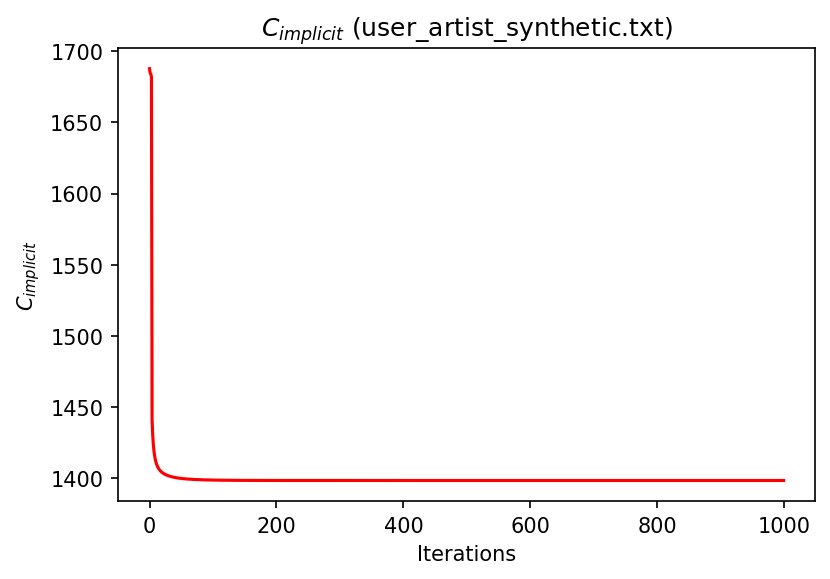

In [0]:
plt.figure()
plt.plot(np.array(c_implicit_history), c='red')
plt.xlabel('Iterations')
plt.ylabel(r'$C_{implicit}$')
plt.title(r'$C_{implicit}$' + ' (user_artist_synthetic.txt)')